##Face Recognition

### Imports

In [228]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import scipy
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.stats import multivariate_normal
from google.colab import drive
from scipy.spatial import distance

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%matplotlib inline

#### 2.1 split the data into training set and testing randomly, such such that 80% are in training set 20% are in test set

In [0]:
def get_train_testSet(path):
    dataSet = []
    for dir in os.listdir(path):
        identity = dir
        dir_path = os.path.join(path, dir)
        if os.path.isdir(dir_path):
            for image in os.listdir(dir_path):
                image_path = os.path.join(dir_path, image)
                if (os.path.isfile(image_path)):
                    currImg = cv2.imread(image_path, 0)
                    currImg = cv2.resize(currImg, None, fx=0.5, fy=0.5)
                    dataSet.append(np.append(currImg.flatten(), int(identity)))
    dataSet = np.vstack(dataSet)
    trainSet, testSet = train_test_split(dataSet, test_size=0.2, shuffle=True)
    return trainSet, testSet

In [0]:
trainSet, testSet = get_train_testSet('Color FERET Database')
trainSetX = trainSet[:, :-1].copy()

### 2.1 PCA

#### separate the training set data and labels, calculate the mean and subtract the mean from each of the training set images

In [0]:
trainSetX = trainSetX.astype('float')
trainMean = np.mean(trainSetX,axis=0)
for i in range(trainSetX.shape[0]):
    trainSetX[i] -=  trainMean
trainSetY = trainSet[:, -1].copy()

In [0]:
def eigenVal(data):
    Dt = np.transpose(data)
    C = Dt@data
    eigen_value, eigen_vector = scipy.linalg.eig(C)
    eigen_vector = data@eigen_vector
    return eigen_value.astype('float'), eigen_vector.astype('float')

In [0]:
def visualize(a,subplot = False):
  a = a.reshape(384,256)
  plt.imshow(a,'gray')
  plt.show()

###2.1.1 compute the principal components and display the mean face and first 10 eigenfaces

In [116]:
data = np.transpose(trainSetX)
eigen_value, eigen_vector = eigenVal(data)


(98304, 1623)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  


#### mean face

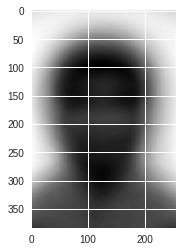

In [229]:
visualize(trainMean.astype('int'))

#### first 10 eigen faces

eigenface #0


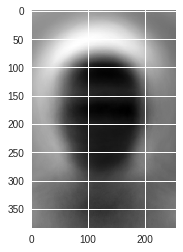

eigenface #1


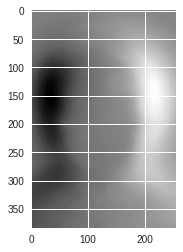

eigenface #2


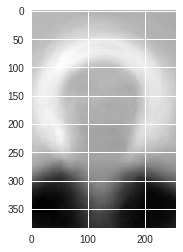

eigenface #3


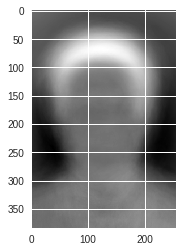

eigenface #4


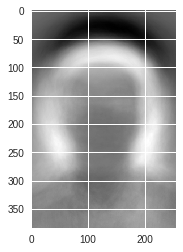

eigenface #5


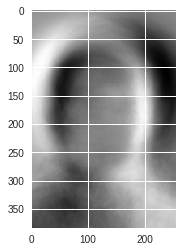

eigenface #6


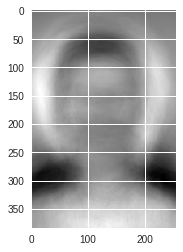

eigenface #7


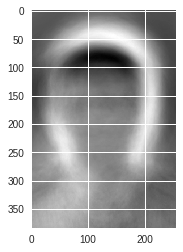

eigenface #8


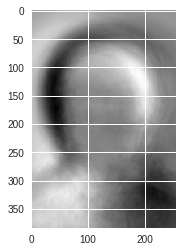

eigenface #9


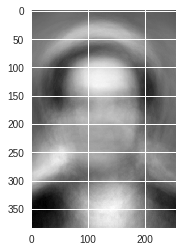

In [215]:
for i in range(10):
  print ('eigenface #{}'.format(i))
  visualize(eigen_vector[:,i])

### 2.1.2 decide the number of principle components

In [0]:
def find_optimal_number_of_eigenfaces(eigen_value,fraction_to_represent):
  sum_eigen_value = np.sum(eigen_value)
  current_sum = 0
  for i in range(eigen_value.size):
    current_sum += eigen_value[i]
    fraction_of_var = current_sum/sum_eigen_value
    if fraction_of_var > fraction_to_represent:
      return i+1

In [227]:
fraction_of_var = 0.85
num = find_optimal_number_of_eigenfaces(eigen_value,fraction_of_var)
print('the number of eigenfaces to represent {} of the total variance is {}'.format(fraction_of_var,num))

the number of eigenfaces to represent 0.85 of the total variance is 48


### eigenface vector

In [0]:
U =  eigen_vector[:,:20]

### 2.2.2 find the coefficient for each Training image 

In [0]:
def getPhi(im,u):
  w = np.transpose(u)@im
  return w

####store the coeficients for a single person in one entry of a hash table, and the hash table has n (number of identities) elements

In [0]:
faceDict = {}
for i in range(trainSetX.shape[0]):
  id = trainSetY[i]
  if id not in faceDict:
    faceDict[id] = []
  faceDict[id].append(getPhi(np.transpose(trainSetX[i]),U))
for i in faceDict:
  faceDict[i] = np.vstack(faceDict[i])

### 2.2.3 Build 52 Gaussian Density function for likelihood, one for each subject. here each gaussian is represented by the mean and covarance matrix

In [0]:
a = getPhi(np.transpose(trainSetX[1]),U)

gaussianModels = {}
for k in faceDict:
  meanY = np.mean(faceDict[k],axis = 0)
  covY = np.cov(np.transpose(faceDict[k]))
  gaussianModels[k] = {'mean':meanY,'cov':covY}

###2.2.4 testing using test set

####split the test data and label

In [207]:
testSetX = testSet[:,:-1]
testSetY = testSet[:,-1]
print(faceDict[93].shape)

(29, 20)


#### find the eigen representation of each test image

In [0]:
testPhi = []
for i in testSetX:
  testPhi.append(getPhi(np.transpose(i-trainMean),U))
testPhi = np.vstack(testPhi)

####calculate the prior of an identity

In [0]:
unique, count = np.unique(trainSetY,return_counts=True)
priorY = dict(zip(unique,count/trainSetY.size))

####Making predictions using MAP

In [0]:
resultID = []
for i in range(testPhi.shape[0]):
  posterior = []
  ids  =[]
  for j in gaussianModels:
    curr = multivariate_normal.pdf(testPhi[i],gaussianModels[j]['mean'],gaussianModels[j]['cov'],True)*priorY[j]
    posterior.append(curr)
    ids.append(j)
  prediction = np.argmax(posterior)
  resultID.append(ids[prediction])   

In [232]:
print('accruacy for MAP method is {}'.format(accuracy_score(resultID,testSetY)))

accruacy for MAP method is 0.5024630541871922


#### displaying the posterior of one image

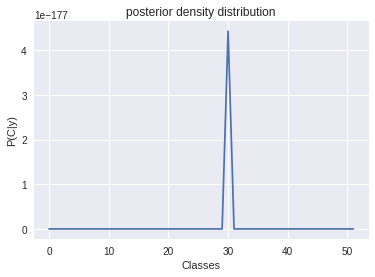

the perdicted label is 760
the actrual label is 760


In [245]:
plt.plot(posterior)
plt.title('posterior density distribution')
plt.ylabel('P(C|y)')
plt.xlabel('Classes')
plt.show()
print('the perdicted label is '+str(ids[30]))
print('the actrual label is ' +str(testSetY[-1]))

#### making predictions using nearest neighbor classifier

In [0]:
resultID = []
for i in range(testPhi.shape[0]):
  distance = []
  ids = []
  for id in faceDict:
    currDist = []
    for img in faceDict[id]:
      currDist.append(np.linalg.norm(testPhi[i]-img))
      #distance.euclidean(a, b)
    distance.append(min(currDist))
    ids.append(id)
  prediction = np.argmin(distance)
  resultID.append(ids[prediction])

In [213]:
print('accruacy for nearest neighbor method is {}'.format(accuracy_score(resultID,testSetY)))

accruacy for nearest neighbor method is 0.5320197044334976
